# Capítulo 4 - Técnicas de Validación

En este apartado se presentan las técnicas de validación que se aplicarán en los experimentos. El objetivo no es detallar la teoría, sino explicar brevemente cómo se usan en el flujo de trabajo.

## Métricas utilizadas

Para evaluar los modelos se aplican tanto métricas clásicas como métricas específicas para series temporales con anomalías:

- **Precisión, Recall, F1, PR-AUC y ROC-AUC:** permiten medir el rendimiento a nivel puntual de cada predicción.  
- **NAB Score (Numenta Anomaly Benchmark):** recompensa las detecciones tempranas dentro de ventanas de anomalía y penaliza los falsos positivos.  
- **Window Coverage:** mide qué proporción de cada ventana de anomalía ha sido cubierta por las detecciones del modelo.  

Este conjunto de métricas combina una visión clásica con medidas adaptadas al carácter temporal y de intervalo de las anomalías.


## Estrategias de validación temporal

- **Time Series Cross Validation (Expanding Window):** se entrena el modelo con un bloque inicial que se va ampliando en cada iteración.  
- **Rolling-Origin Evaluation (Walkforward):** se entrena con la ventana inmediatamente anterior y se valida en la siguiente, adecuado para escenarios de actualización progresiva.  

Estas técnicas permiten evaluar y comparar distintos detectores de anomalías respetando la naturaleza temporal de los datos.

## Preprocesamiento con filtro de Hampel

Antes de entrenar cada modelo en los bloques de validación temporal, los conjuntos de entrenamiento se limpian con un **filtro de Hampel**.  
Este método detecta y repara valores atípicos reemplazándolos por la mediana local (o reduciéndolos en amplitud), evitando que outliers extremos distorsionen el ajuste del modelo.  

De esta forma, se asegura que el entrenamiento se realice sobre una señal más robusta y representativa, especialmente importante en escenarios con ruido o anomalías puntuales muy intensas.


## NAB: Numenta Anomaly Benchmark

El NAB define un esquema de evaluación para detección de anomalías en series temporales.  
Su idea principal es asignar **recompensas** o **penalizaciones** en función de:

- **Detecciones tempranas** dentro de la ventana de anomalía → mayor recompensa.  
- **Detecciones tardías o fuera de ventana** → menor recompensa o penalización.  
- **Falsos positivos** fuera de cualquier ventana → penalización proporcional.  

Además, el NAB extiende cada ventana de anomalía para tolerar pequeñas desviaciones temporales.


### 1. Ventanas de anomalía

El NAB trabaja sobre **ventanas temporales de anomalía**.  
Partimos de un array binario `y_true` donde `1` indica anomalía y `0` normalidad.  

Ejemplo: dos anomalías en los intervalos `[20, 30]` y `[50, 70]`.


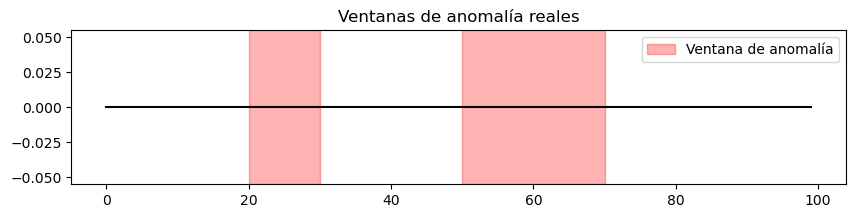

In [4]:
n = 100
anomalies = [(20, 30), (50, 70)]
time = np.arange(0, n)

# Representamos visualmente las ventanas
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 2))
plt.plot(time, np.zeros(n), color="black")
for (s, e) in anomalies:
    plt.axvspan(s, e, color="red", alpha=0.3, label="Ventana de anomalía" if s==20 else "")
plt.legend()
plt.title("Ventanas de anomalía reales")
plt.show()

### 2. Ventanas extendidas

El NAB extiende cada ventana real hacia los lados.  
Esto permite tolerar detecciones que se adelantan o retrasan levemente.  


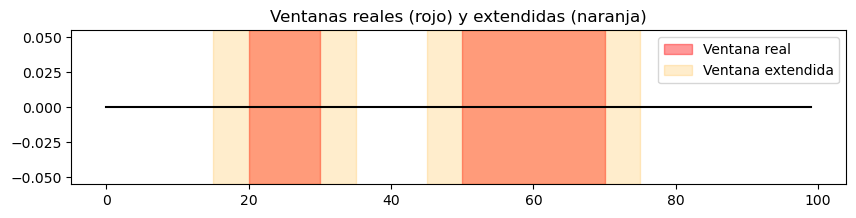

In [7]:
from modelos.validation_metrics import extend_window
import numpy as np
import matplotlib.pyplot as plt

extended_anomalies = [extend_window(s, e, n, ratio=0.2, min_ext=5) for (s, e) in anomalies]

time = np.arange(0, n)

plt.figure(figsize=(10, 2))
plt.plot(time, np.zeros(n), color="black")

# Ventanas reales en rojo
for (s, e) in anomalies:
    plt.axvspan(s, e, color="red", alpha=0.4, label="Ventana real" if s == anomalies[0][0] else "")

# Ventanas extendidas en naranja
for (s_ext, e_ext) in extended_anomalies:
    plt.axvspan(s_ext, e_ext, color="orange", alpha=0.2, label="Ventana extendida" if s_ext == extended_anomalies[0][0] else "")

plt.legend()
plt.title("Ventanas reales (rojo) y extendidas (naranja)")
plt.show()


### 3. Recompensa NAB

La función `nab_reward` asigna puntuaciones:  
- +1 si se detecta justo al inicio de la ventana.  
- 0 si se detecta al final.  
- Valores negativos si la detección se aleja demasiado.  


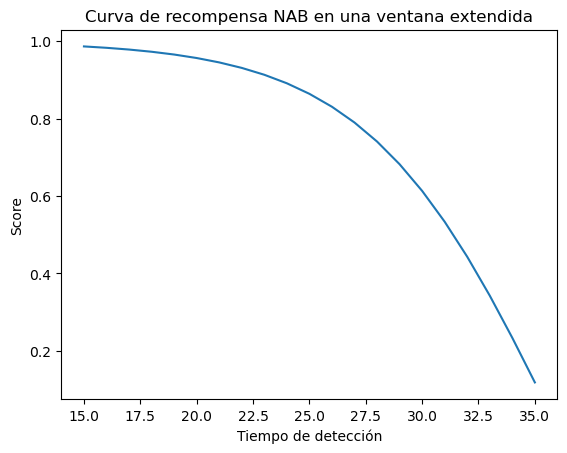

In [8]:
from modelos.validation_metrics import nab_reward

s_ext, e_ext = extended_anomalies[0]
scores_demo = [nab_reward(t, s_ext, e_ext) for t in range(s_ext, e_ext+1)]

plt.plot(range(s_ext, e_ext+1), scores_demo)
plt.title("Curva de recompensa NAB en una ventana extendida")
plt.xlabel("Tiempo de detección")
plt.ylabel("Score")
plt.show()

### 4. Detecciones simuladas

Vamos a simular predicciones del modelo en diferentes momentos.  
Algunas caen dentro de ventanas y otras fuera.  


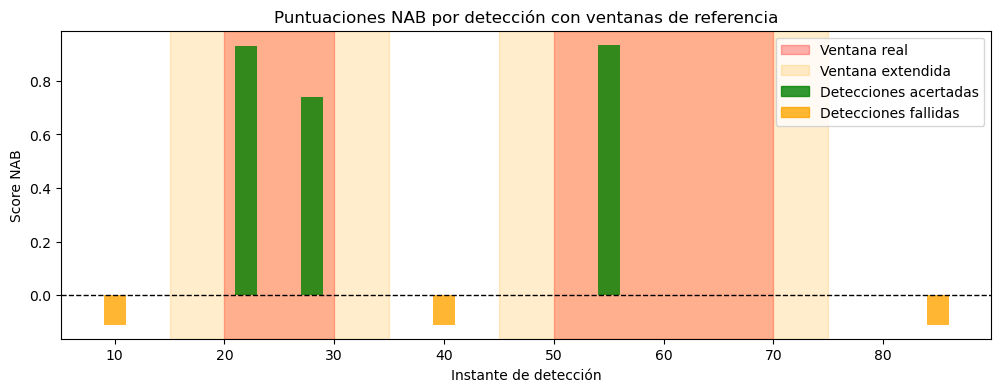

In [12]:
import matplotlib.patches as mpatches

A_TP, A_FP = 1.0, 0.11
detections = [10, 22, 28, 40, 55, 85]  # mezcla de aciertos y falsos positivos

def score_detection(t):
    for (s_ext, e_ext) in extended_anomalies:
        if s_ext <= t <= e_ext:
            return nab_reward(t, s_ext, e_ext, A_TP=A_TP)
    return -A_FP

scores = [score_detection(d) for d in detections]

# --- Visualización ---
plt.figure(figsize=(12,4))

# Ventanas reales (rojo)
for (s, e) in anomalies:
    plt.axvspan(s, e, color="red", alpha=0.3, label="Ventana real" if s == anomalies[0][0] else "")

# Ventanas extendidas (naranja)
for (s_ext, e_ext) in extended_anomalies:
    plt.axvspan(s_ext, e_ext, color="orange", alpha=0.2, label="Ventana extendida" if s_ext == extended_anomalies[0][0] else "")

# Barras con puntuaciones de detecciones
colors = ["green" if s > 0 else "orange" for s in scores]
plt.bar(detections, scores, color=colors, width=2, alpha=0.8)

# Línea base
plt.axhline(0, color="black", linestyle="--", linewidth=1)

# Etiquetas personalizadas en la leyenda
patch_real = mpatches.Patch(color='red', alpha=0.3, label='Ventana real')
patch_ext = mpatches.Patch(color='orange', alpha=0.2, label='Ventana extendida')
patch_ok = mpatches.Patch(color='green', alpha=0.8, label='Detecciones acertadas')
patch_fail = mpatches.Patch(color='orange', alpha=0.8, label='Detecciones fallidas')

plt.legend(handles=[patch_real, patch_ext, patch_ok, patch_fail])

plt.xlabel("Instante de detección")
plt.ylabel("Score NAB")
plt.title("Puntuaciones NAB por detección con ventanas de referencia")
plt.show()


### 5. Visualización global

Ahora mostramos la serie temporal, las ventanas y las detecciones, junto con la puntuación NAB que obtienen.  


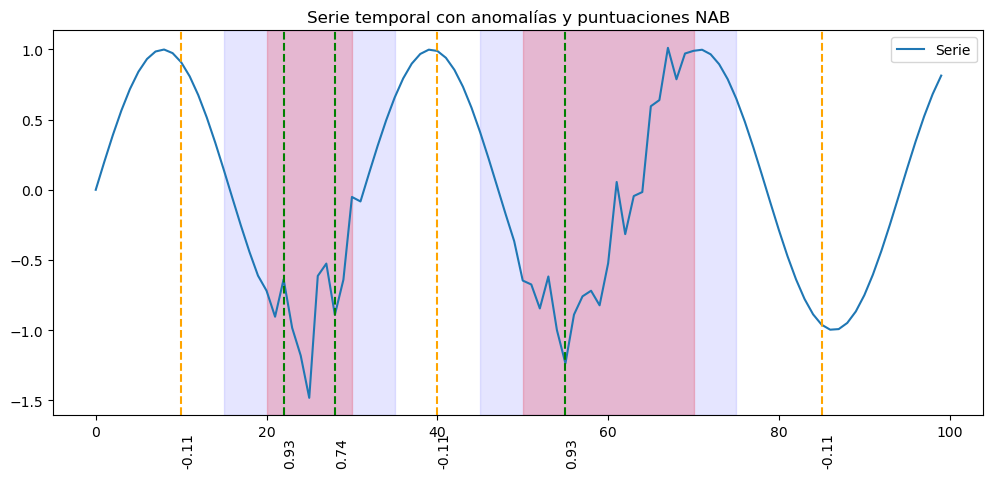

In [14]:
series = np.sin(time/5)
# añadimos pequeñas perturbaciones en las anomalías
for (s, e) in anomalies:
    series[s:e+1] += np.random.normal(0, 0.2, e-s+1)

plt.figure(figsize=(12,5))
plt.plot(time, series, label="Serie temporal")

# Ventanas
for (s, e) in anomalies:
    plt.axvspan(s, e, color="red", alpha=0.2)
for (s_ext, e_ext) in extended_anomalies:
    plt.axvspan(s_ext, e_ext, color="blue", alpha=0.1)

# Detecciones
for d, s in zip(detections, scores):
    plt.axvline(d, color=("green" if s>0 else "orange"), linestyle="--")
    plt.text(d, series.min()-0.5, f"{s:.2f}", rotation=90, va="bottom")

plt.title("Serie temporal con anomalías y puntuaciones NAB")
plt.legend(["Serie"])
plt.show()


**Interpretación**  
- Las detecciones verdes son aciertos dentro de ventanas, con mayor puntuación cuanto más tempranas.  
- Las detecciones naranjas están fuera de cualquier ventana → se consideran falsos positivos y se penalizan.  

De esta forma, el NAB combina detección temprana y penalización de errores en un solo score normalizado.


## Window Coverage

El **Window Coverage** mide qué proporción de cada ventana de anomalía ha sido cubierta por detecciones.  
A diferencia de métricas puntuales como la precisión o el recall, aquí se evalúa a nivel de **intervalo**, calculando el porcentaje de cobertura en cada anomalía y devolviendo el promedio global.

Ejemplo:  
- Si una ventana de 10 instantes tiene 5 instantes marcados como anomalía → cobertura = 0.5.  
- Si está totalmente cubierta → cobertura = 1.0.  
- Si no hay ninguna detección en la ventana → cobertura = 0.0.  


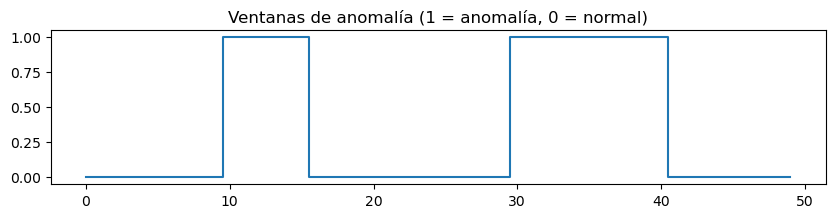

In [15]:
# Creamos un ejemplo sencillo
import numpy as np
import matplotlib.pyplot as plt

n = 50
y_true = np.zeros(n)
y_true[10:16] = 1   # anomalía 1
y_true[30:41] = 1   # anomalía 2

plt.figure(figsize=(10,2))
plt.plot(y_true, drawstyle="steps-mid")
plt.title("Ventanas de anomalía (1 = anomalía, 0 = normal)")
plt.show()


Ahora simulamos predicciones:  
- En la primera ventana detectamos solo la mitad.  
- En la segunda ventana cubrimos menos de la mitad.


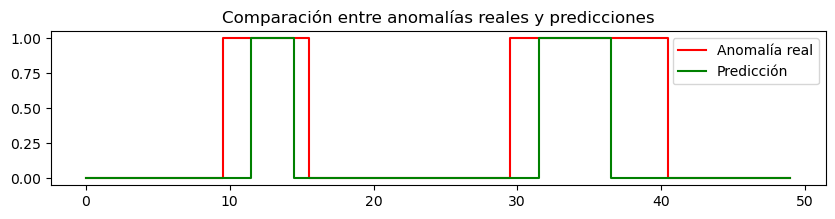

In [16]:
y_pred = np.zeros(n)
y_pred[12:15] = 1   # parcial en ventana 1
y_pred[32:37] = 1   # parcial en ventana 2

plt.figure(figsize=(10,2))
plt.plot(y_true, drawstyle="steps-mid", label="Anomalía real", color="red")
plt.plot(y_pred, drawstyle="steps-mid", label="Predicción", color="green")
plt.legend()
plt.title("Comparación entre anomalías reales y predicciones")
plt.show()


In [17]:
def window_coverage_metric(y_true, y_pred):
    y_true = np.asarray(y_true).astype(int)
    y_pred = np.asarray(y_pred).astype(int)

    n = len(y_true)
    coverages = []
    in_anomaly = False
    anomalies = []

    # localizar ventanas
    for i in range(n):
        if y_true[i] == 1 and not in_anomaly:
            start = i
            in_anomaly = True
        elif y_true[i] == 0 and in_anomaly:
            anomalies.append((start, i-1))
            in_anomaly = False
    if in_anomaly:
        anomalies.append((start, n-1))

    # calcular cobertura
    for (start, end) in anomalies:
        window_len = end - start + 1
        hits = sum(y_pred[start:end+1])
        coverages.append(hits / window_len)

    return np.mean(coverages) if coverages else 0.0

window_coverage_metric(y_true, y_pred)

0.4772727272727273

En este caso:  
- Ventana 1 (10-15): 6 instantes → 3 detectados → cobertura 0.5.  
- Ventana 2 (30-40): 11 instantes → 5 detectados → cobertura ≈ 0.45.  
- Cobertura media ≈ 0.48.  

El **Window Coverage** resume cuánta parte de las anomalías el modelo consigue cubrir.


## ROC-AUC y PR-AUC

Además de las métricas específicas (NAB, Window Coverage), también usamos métricas clásicas basadas en puntuaciones continuas:

- **ROC-AUC:** mide la capacidad de distinguir entre normales y anómalos en distintos umbrales.  
- **PR-AUC:** más adecuada en escenarios desbalanceados, mide la relación entre precisión y recall.


In [28]:
from sklearn.metrics import roc_auc_score, average_precision_score, RocCurveDisplay, PrecisionRecallDisplay
import numpy as np
import matplotlib.pyplot as plt

# Datos más grandes: 10k normales y 1k anomalías
n_normals, n_anoms = 10000, 1000
y_true = np.array([0]*n_normals + [1]*n_anoms)

# Generamos scores con solapamiento moderado
rng = np.random.default_rng(42)
y_scores = np.concatenate([
    rng.normal(0.35, 0.15, n_normals),   # normales
    rng.normal(0.7, 0.15, n_anoms)       # anomalías
])
y_scores = np.clip(y_scores, 0, 1)

roc_auc = roc_auc_score(y_true, y_scores)
pr_auc = average_precision_score(y_true, y_scores)

print(f"ROC-AUC: {roc_auc:.3f}, PR-AUC: {pr_auc:.3f}")

ROC-AUC: 0.950, PR-AUC: 0.748


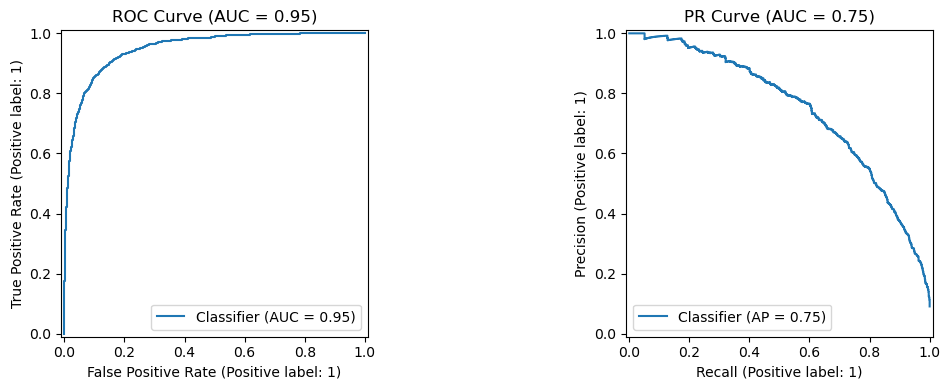

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))

RocCurveDisplay.from_predictions(y_true, y_scores, ax=axes[0])
axes[0].set_title(f"ROC Curve (AUC = {roc_auc:.2f})")

PrecisionRecallDisplay.from_predictions(y_true, y_scores, ax=axes[1])
axes[1].set_title(f"PR Curve (AUC = {pr_auc:.2f})")

plt.tight_layout()
plt.show()


### Interpretación

- **ROC Curve (Receiver Operating Characteristic):**  
  Representa la relación entre:
  - **TPR (True Positive Rate o Recall)** en el eje Y  
  - **FPR (False Positive Rate)** en el eje X  
  A medida que movemos el umbral de decisión, se dibuja la curva.  
  El **AUC (Área bajo la curva)** mide la capacidad del modelo de separar positivos de negativos;  
  0.5 indica azar, 1.0 indica separación perfecta.

- **PR Curve (Precision-Recall):**  
  Representa la relación entre:
  - **Precisión (Precision)** en el eje Y  
  - **Exhaustividad (Recall)** en el eje X  
  Es especialmente informativa en problemas desbalanceados, ya que muestra cómo la precisión cae al intentar detectar más positivos.  
  El **PR-AUC** resume el equilibrio entre ambas métricas: valores más altos indican que el modelo consigue detectar anomalías sin sacrificar demasiada precisión.


## Validación temporal: Expanding Window (TSCV)

En la validación cruzada para series temporales no se pueden mezclar datos pasados y futuros.  
Una estrategia habitual es el **Expanding Window (TSCV)**:  

- El conjunto de entrenamiento empieza con una ventana inicial.  
- En cada iteración se amplía la ventana de train.  
- La validación siempre ocupa un bloque contiguo justo después del entrenamiento.  


In [32]:
import numpy as np

T = 60          # longitud de la serie
L_train = 20    # tamaño inicial de entrenamiento
L_val = 10      # tamaño fijo de validación
S = 10          # desplazamiento entre splits

splits = []
start_val = L_train
while start_val + L_val <= T:
    splits.append((
        np.arange(0, start_val),                # indices train
        np.arange(start_val, start_val+L_val)   # indices val
    ))
    start_val += S

len(splits), splits[0]


(4,
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19]), array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29])))

Cada split contiene los índices de train y validación.  
En este ejemplo se generan varias particiones respetando el orden temporal.
Ahora visualizamos cómo evoluciona la división en una serie sintética.


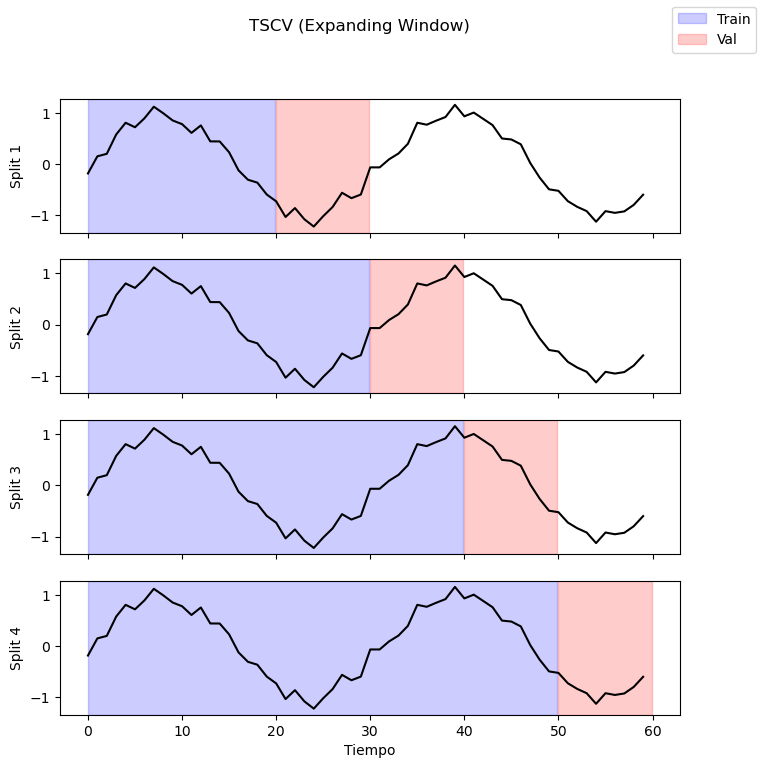

In [41]:
import matplotlib.pyplot as plt

time = np.arange(T)
series = np.sin(time/5) + 0.1*np.random.randn(T)

fig, axes = plt.subplots(len(splits), 1, figsize=(8, 8), sharex=True)

for i, (tr, va) in enumerate(splits):
    ax = axes[i]
    ax.plot(time, series, color="black")
    ax.axvspan(tr[0], tr[-1]+0.9, color="blue", alpha=0.2, label="Train" if i==0 else None)
    ax.axvspan(va[0], va[-1]+0.9, color="red", alpha=0.2, label="Val" if i==0 else None)

    ax.set_ylabel(f"Split {i+1}")

# leyenda global
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")

plt.xlabel("Tiempo")
plt.suptitle("TSCV (Expanding Window)")
plt.show()


Aquí vemos cómo la ventana de entrenamiento crece en cada iteración,
mientras que los bloques de validación se van desplazando hacia adelante sin solaparse.


## Walkforward (single-block update)

Otra forma de validación temporal es el **walk-forward por bloques**.  

- La serie se divide en bloques consecutivos sin solapamiento.  
- En cada iteración:
  - El modelo se entrena (o actualiza) solo con el bloque anterior.  
  - Se valida en el siguiente bloque.  
- Después de validar, el bloque validado pasa a ser el nuevo bloque de entrenamiento.

De esta manera el modelo “camina” hacia adelante bloque a bloque.


In [50]:
import numpy as np

T = 60       # longitud total
L_train0 = 15  # tamaño del primer bloque
L_blk = 10     # tamaño de los bloques siguientes

# Construcción de bloques contiguos
blocks = []
blocks.append((0, L_train0-1))  # bloque inicial
start = L_train0
while start + L_blk <= T:
    blocks.append((start, start+L_blk-1))
    start += L_blk

blocks


[(0, 14), (15, 24), (25, 34), (35, 44), (45, 54)]

El resultado es una lista de bloques contiguos **B0, B1, …**.  
En cada iteración `j`:  
- Train = $B_j$  
- Validación = $B_{j+1}$ 


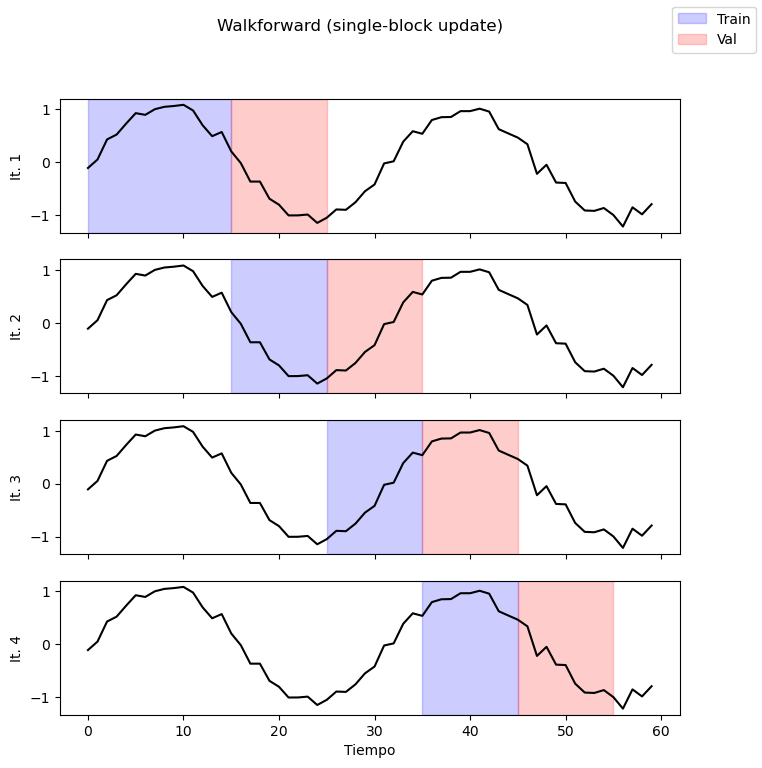

In [51]:
import matplotlib.pyplot as plt

time = np.arange(T)
series = np.sin(time/5) + 0.1*np.random.randn(T)

fig, axes = plt.subplots(len(blocks)-1, 1, figsize=(8, 8), sharex=True)

for j in range(len(blocks)-1):
    tr_s, tr_e = blocks[j]
    va_s, va_e = blocks[j+1]
    
    ax = axes[j]
    ax.plot(time, series, color="black")
    ax.axvspan(tr_s, tr_e+1, color="blue", alpha=0.2, label="Train" if j==0 else None)
    ax.axvspan(va_s, va_e+1, color="red", alpha=0.2, label="Val" if j==0 else None)
    ax.set_ylabel(f"It. {j+1}")

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")
plt.xlabel("Tiempo")
plt.suptitle("Walkforward (single-block update)")
plt.show()


En este esquema:
- El entrenamiento **no acumula todo el pasado**, sino solo el bloque inmediatamente anterior.
- El bloque de validación se va moviendo hacia adelante, sin solapamientos.
- Está pensado para **modelos con entrenamiento incremental**, que pueden actualizarse bloque a bloque sin necesidad de reentrenar con toda la historia.


## Filtro de Hampel

El filtro de Hampel es un método robusto para detectar y corregir valores atípicos en series temporales.  
Se basa en la **mediana local** y la **desviación absoluta mediana (MAD)** dentro de una ventana móvil:

1. Se calcula la mediana en la ventana.  
2. Se mide la desviación de cada punto respecto a esa mediana.  
3. Si la desviación supera un umbral (multiplicador `sigma`), se marca como outlier.  
4. Los outliers pueden repararse sustituyéndolos por la mediana o reduciendo su amplitud.  


In [53]:
import cupy as cp
from cupyx.scipy.ndimage import median_filter
import matplotlib.pyplot as plt

def hampel_gpu(x: cp.ndarray, window: int = 25, sigma: float = 5.0, repair: str = "median", shrink_lambda: float = 0.7):
    k = 1.4826
    med = median_filter(x, size=window, mode="reflect")
    mad = k * median_filter(cp.abs(x - med), size=window, mode="reflect")
    z = cp.abs(x - med) / (mad + 1e-9)
    mask = z > sigma

    x_clean = x.copy()
    if repair == "median":
        x_clean[mask] = med[mask]
    elif repair == "shrink":
        x_clean[mask] = (1.0 - shrink_lambda) * x_clean[mask]

    return x_clean, mask


Probamos el filtro con una serie sintética que contiene anomalías inyectadas.


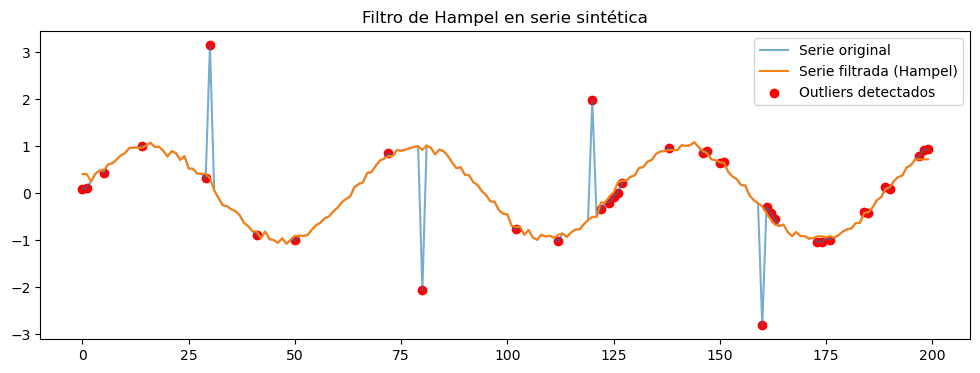

In [54]:
import numpy as np

# Serie con anomalías artificiales
np.random.seed(0)
n = 200
time = np.arange(n)
series = np.sin(time/10) + 0.05*np.random.randn(n)
series[[30, 80, 120, 160]] += [3, -3, 2.5, -2.5]  # picos anómalos

# Convertimos a GPU
series_cp = cp.asarray(series, dtype=cp.float32)

# Aplicamos Hampel
series_clean_cp, mask_cp = hampel_gpu(series_cp, window=15, sigma=3.0, repair="median")
series_clean = cp.asnumpy(series_clean_cp)
mask = cp.asnumpy(mask_cp)

plt.figure(figsize=(12,4))
plt.plot(time, series, label="Serie original", alpha=0.6)
plt.plot(time, series_clean, label="Serie filtrada (Hampel)", linewidth=1.5)
plt.scatter(time[mask], series[mask], color="red", label="Outliers detectados")
plt.legend()
plt.title("Filtro de Hampel en serie sintética")
plt.show()


En el gráfico se observa:
- La serie original con anomalías (picos en rojo).  
- La serie filtrada con el Hampel, donde los outliers fueron reemplazados por la mediana local.  

Este filtro se aplica en cada bloque de entrenamiento de los esquemas TSCV o Walkforward
para reducir el impacto de outliers extremos en el ajuste del modelo.


## Pipeline de Validación

Para comparar modelos de detección de anomalías en series temporales necesitamos un **proceso sistemático** que asegure todo lo anteriormente revisado en este capítulo:

1. **División temporal de los datos** (TS-CV o Walkforward).  
2. **Preprocesamiento** opcional (ej. filtro Hampel para valores extremos).  
3. **Entrenamiento + predicción** en cada split.  
4. **Evaluación de métricas** con resultados agregados.  

De esta forma se automatiza la validación y se evita código repetido.  
El pipeline también permite acelerar el proceso con Dask o Dask-CUDA en GPU.  


### Entrenamiento y predicción

En cada split temporal, el pipeline:
1. Limpia los datos de entrenamiento.  
2. Preprocesa con el método propio del modelo (`preprocess`).  
3. Ajusta el modelo (`fit`).  
4. Predice etiquetas y scores de anomalía en validación.  


In [5]:
import cupy as cp
import cudf
import numpy as np
from modelos.ValidationPipeline import ValidationPipeline
from modelos.validation_metrics import (
    precision_metric, recall_metric, f1_metric,
    roc_auc_metric, nab_metric, window_coverage_metric
)

# Modelo de prueba: detecta como anomalía si la primera feature > 1.0
class ThresholdModel:
    def preprocess(self, X, retrain=False): 
        return X
    def fit(self, X): 
        pass
    def predict(self, X): 
        return (X.iloc[:,0].values > 1.0).astype(cp.int32)
    def anomaly_score(self, X): 
        return X.iloc[:,0].values.astype(cp.float32)

# Configuración de validación
params = {"P_train": 0.6, "num_windows": 5}
metrics = {
    "precision": precision_metric,
    "recall": recall_metric,
    "f1": f1_metric,
    "roc_auc": roc_auc_metric,
    "nab": nab_metric,
    "window_coverage": window_coverage_metric,
}

pipe = ValidationPipeline(
    model=ThresholdModel(),
    metrics=metrics,
    mode="tscv",
    params=params,
    hampel_cfg={}   # sin filtro Hampel en este ejemplo
)

# Datos sintéticos en GPU
cp.random.seed(42)
X = cudf.DataFrame(cp.random.randn(200, 3).astype("float32"))
y = cudf.Series(cp.random.choice(cp.array([0, 1]), size=200, p=[0.85, 0.15]))

# Ejecutamos validación
results = pipe.validate(X, y)
print("Resultados métricas:", results)


Resultados métricas: {'precision': 0.04, 'recall': 0.1, 'f1': 0.05714285714285714, 'roc_auc': 0.32005494505494503, 'nab': 0.5580865023744497, 'window_coverage': 0.1}


## Conclusión del capítulo

En este capítulo hemos revisado las piezas clave para validar modelos de detección de anomalías en series temporales:  

- **Métricas clásicas** (precisión, recall, F1, ROC-AUC, PR-AUC) para medir el rendimiento puntual.  
- **Métricas específicas** (NAB, Window Coverage) que incorporan la naturaleza temporal y por ventanas de las anomalías.  
- **Protocolos de validación temporal** (TSCV y Walkforward) que respetan el orden cronológico en el entrenamiento y la evaluación.  
- **Preprocesamiento robusto** con el filtro de Hampel para reducir el impacto de valores extremos.  
- **Pipeline de validación** que automatiza este flujo y facilita la comparación de modelos bajo un mismo esquema.  

Con esta base, ya disponemos de un marco estandarizado y reproducible para evaluar cualquier detector.  

En el siguiente capítulo aplicaremos este pipeline sobre el primer modelo implementado: **PCA (Principal Component Analysis)**, que servirá como línea base inicial para los experimentos.  
